## Business Understanding

### BO: Developing a comprehensive satellite imagery analysis platform powered by Mask R-CNN with multiple optimizers aims to enhance environmental monitoring, urban planning, and disaster response efforts.
    
### DSO: Applying Mask R-CNN with all the 6 optimizers to detect all the possible objects when using the sattelite

## Date Understanding

There are positives , negatives images and groud truth files.

ground truth files are the annotations for the images : box[x1,y1,x2,y2],class which respresents an object

There are 10 classes in total

An image could contain more than one object

negatives images are images that are not annotated (no bboxes and class) => We are not going to use them for training and test

Positives images have 3896 objects in total.



## Date Preparation

In [2]:
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.layers import Dense,Flatten
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import zipfile
import pandas as pd
import cv2
import sys
from torch.utils.data import Dataset, DataLoader


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '../input/dataset/Dataset/positive image set'

#extracted_files = os.listdir(data_path)

annotation_path = '../input/dataset/Dataset/ground truth'


In [4]:
#extracted_files

In [5]:
#!pip install mrcnn

In [6]:
#!pip install keras

In [7]:
#import mrcnn
#import mrcnn.utils
#from keras.utils import Sequence
#from mrcnn.visualize import display_top_masks
#import mrcnn.visualize
#from numpy import zeros
#from mrcnn.config import Config

#from mrcnn import model as modellib

In [8]:
dataset = 'NWPU VHR-10 dataset'
classnames = ["airplane","ship","storage tank", "baseball diamond", "tenis court", "basketball court","ground track field","harbor","bridge","vehicle"]

In [9]:
import os
import pandas as pd
import cv2

def create_df(datapath, annotation_path):
    """
    Cette fonction crée un DataFrame pandas contenant les annotations de boîtes englobantes pour les images.

    Args:
        datapath (str): Le chemin vers le répertoire contenant les images.
        annotation_path (str): Le chemin vers le répertoire contenant les annotations.

    Returns:
        DataFrame: Un DataFrame pandas avec des colonnes représentant l'identifiant de l'image, la largeur de l'image,
        la hauteur de l'image, les coordonnées de la boîte englobante (x1, y1, x2, y2) et la classe de l'objet.
    """
    # Créer un DataFrame vide avec les colonnes spécifiées
    df = pd.DataFrame(columns=['imageid','width','height','x1','y1','x2','y2','class'])

    # Lister tous les fichiers dans datapath
    extracted_files = os.listdir(datapath)

    # Itérer sur chaque fichier dans datapath
    for filename in extracted_files:
        # Initialiser des listes pour stocker les coordonnées de la boîte englobante et les classes
        boxes = list()
        classes = list()

        # Ouvrir le fichier d'annotation correspondant au fichier image actuel
        with open(os.path.join(annotation_path, filename.replace('jpg','txt')), 'r') as f:
            # Lire l'image
            image = cv2.imread(os.path.join(datapath, filename))
            height, width, c = image.shape  # Obtenir les dimensions de l'image

            # Lire chaque ligne dans le fichier d'annotation
            lines = f.readlines()
            for line in lines:
                # Supprimer les parenthèses et diviser la ligne en parties
                line = line.replace('(', '').replace(')', '')
                parts = line.strip().split(',')

                # Extraire les coordonnées et la classe de l'objet à partir des parties
                if len(parts) == 5:  # En supposant que chaque ligne a le format (x1,y1),(x2,y2),classe
                    coordinates = parts[0].split() + parts[1].split() + parts[2].split() + parts[3].split()
                    xmin, ymin, xmax, ymax = map(int, coordinates)
                    object_class = int(parts[4])

                    # Ajouter les informations au DataFrame
                    df.loc[len(df)] = [filename.replace('.jpg',''), width, height, xmin, ymin, xmax, ymax, object_class]

    return df


In [10]:
df = create_df(data_path,annotation_path)
df.head()

,imageid,width,height,x1,y1,x2,y2,class
0,623,936,551,500,65,776,388,7
1,623,936,551,135,25,212,89,4
2,623,936,551,343,27,442,112,4
3,623,936,551,236,93,330,171,4
4,623,936,551,324,273,454,380,4


In [11]:
df[df['imageid'] == '432']

,imageid,width,height,x1,y1,x2,y2,class
2772,432,1072,710,718,293,751,346,10
2773,432,1072,710,781,271,815,332,10
2774,432,1072,710,970,235,1006,288,10


In [12]:
df.columns

Index(['imageid', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class'], dtype='object')

In [13]:
def df_list(dataframe):
    """
    Convertit un DataFrame contenant des données d'images avec des boîtes englobantes et des classes en une liste de dictionnaires.

    Args:
        dataframe (pandas.DataFrame): DataFrame contenant les données d'images.

    Returns:
        list: Liste de dictionnaires représentant chaque image avec ses informations et les listes des boîtes englobantes et des classes associées.
    """

    # Regrouper le DataFrame par 'imageid', 'width', et 'height'
    grouped = dataframe.groupby(['imageid', 'width', 'height'])

    # Initialiser la liste de résultats
    result = []

    # Itérer sur chaque groupe
    for name, group in grouped:
        # Créer des listes pour les boîtes et les classes
        boxes_list = []
        classes_list = []

        # Itérer sur les lignes du groupe
        for _, row in group.iterrows():
            # Ajouter les coordonnées de la boîte à la liste des boîtes
            boxes_list.append([row['x1'], row['y1'], row['x2'], row['y2']])
            # Ajouter la classe à la liste des classes
            classes_list.append(row['class'])

        # Ajouter les informations de l'image et les listes à la liste de résultats
        result.append({
            'imageid': name[0],
            'width': name[1],
            'height': name[2],
            'boxes': boxes_list,
            'classes': classes_list
        })

    return result


In [14]:
import torch
import collections
HEIGHT=1024
WIDTH=1024

In [16]:
print(len(df))
df.groupby('class').size().reset_index(name='total_objects')

3896


,class,total_objects
0,1,757
1,2,302
2,3,655
3,4,390
4,5,524
5,6,159
6,7,163
7,8,224
8,9,124
9,10,598


In [18]:
def create_train_test_df(dataframe):
    """
    Divise le DataFrame en ensembles d'entraînement et de test en fonction des totaux désirés pour chaque classe.

    Args:
        dataframe (pandas.DataFrame): DataFrame contenant les données d'images avec des classes.

    Returns:
        tuple: Un tuple contenant deux DataFrames, l'ensemble d'entraînement et l'ensemble de test.
    """
    # Initialiser les DataFrames d'entraînement et de test
    train_df = pd.DataFrame(columns=dataframe.columns)
    test_df = pd.DataFrame(columns=dataframe.columns)

    # Nombre d'objets désiré par classe
    class_desired_totals = {1: 530, 2: 208, 3: 464, 4: 275, 5: 368, 6: 111, 7: 133, 8: 157, 9: 87, 10: 425}

    # Pour chaque classe et son nombre désiré d'objets
    for class_id, desired_total in class_desired_totals.items():
        # Filtrer le DataFrame pour ne garder que les lignes de la classe en cours
        filtered_df = dataframe[dataframe['class'] == class_id]

        # Regrouper les objets par identifiant d'image et calculer le nombre total d'objets par image
        objects_per_image = filtered_df.groupby('imageid').size().reset_index(name='total_objects')

        # Trier les images par nombre d'objets en ordre décroissant
        sorted_objects = objects_per_image.sort_values(by='total_objects', ascending=False)

        # Sélectionner les images pour l'ensemble d'entraînement en respectant le nombre désiré d'objets
        selected_images = []
        remaining_total = desired_total
        for index, row in sorted_objects.iterrows():
            if remaining_total >= row['total_objects']:
                if not train_df[train_df["imageid"]==row['imageid']].empty:
                    # Si l'image est déjà dans l'ensemble d'entraînement, passer à la suivante
                    remaining_total -= row['total_objects']
                    continue
                if remaining_total == 7 and class_id == 10 and row['total_objects'] == 6:
                    # Pour le cas spécial où il reste 7 objets à sélectionner pour la classe 10
                    # et qu'il y a une image avec 6 objets, passer à l'image suivante
                    continue
                # Ajouter l'image à la sélection
                selected_images.append({'imageid': row['imageid'], 'selected_count': row['total_objects']})
                remaining_total -= row['total_objects']
            elif remaining_total == 7 and class_id == 10 and row['total_objects'] == 5:
                # Pour le cas spécial où il reste 7 objets à sélectionner pour la classe 10
                # et qu'il y a une image avec 5 objets, ajouter l'image à la sélection
                selected_images.append({'imageid': row['imageid'], 'selected_count': row['total_objects']})
                remaining_total -= row['total_objects']
            elif remaining_total == 0:
                # Si le nombre désiré d'objets pour la classe est atteint, sortir de la boucle
                break

        # Créer un DataFrame pour l'ensemble d'entraînement basé sur les images sélectionnées
        selected_df = pd.DataFrame(selected_images)
        train_subset = pd.merge(dataframe, selected_df['imageid'], on='imageid')
        train_df = pd.concat([train_df, train_subset])

    # Ajouter les images restantes à l'ensemble de test
    test_df = dataframe[~dataframe['imageid'].isin(train_df['imageid'])]

    return train_df, test_df


In [19]:
train_df, test_df = create_train_test_df(df)

In [20]:
train_df

,imageid,width,height,x1,y1,x2,y2,class
0,029,740,656,66,186,142,272,1
1,029,740,656,204,191,268,260,1
2,029,740,656,297,190,361,261,1
3,029,740,656,374,197,433,255,1
4,029,740,656,448,199,505,251,1
...,...,...,...,...,...,...,...,...
420,431,1059,699,466,313,510,349,10
421,431,1059,699,509,333,555,370,10
422,431,1059,699,289,306,329,353,10
423,431,1059,699,170,520,202,563,10


In [21]:
train_df_list = df_list(train_df)
test_df_list = df_list(test_df)

In [30]:
#train_df_list #Liste contenant un dictionnaire qui comprend les données de chaques images ayant les mêmes: imageid, width, height.
#Exemple:
"""
[{'imageid': '011',
  'width': 969,
  'height': 742,
  'boxes': [[182, 251, 280, 347],
   [286, 226, 378, 322],
   [403, 178, 453, 222],
   [635, 149, 731, 241],
   [664, 245, 775, 344],
   [696, 346, 807, 439],
   [752, 451, 820, 514],
   [736, 531, 817, 608],
   [683, 590, 739, 644]],
  'classes': [1, 1, 1, 1, 1, 1, 1, 1, 1]},
"""

"\n[{'imageid': '011',\n  'width': 969,\n  'height': 742,\n  'boxes': [[182, 251, 280, 347],\n   [286, 226, 378, 322],\n   [403, 178, 453, 222],\n   [635, 149, 731, 241],\n   [664, 245, 775, 344],\n   [696, 346, 807, 439],\n   [752, 451, 820, 514],\n   [736, 531, 817, 608],\n   [683, 590, 739, 644]],\n  'classes': [1, 1, 1, 1, 1, 1, 1, 1, 1]},\n"

In [ ]:
#train_df.groupby('class').size().reset_index(name='total_objects')

In [ ]:
#test_df.groupby('class').size().reset_index(name='total_objects')

In [22]:
test_df

,imageid,width,height,x1,y1,x2,y2,class
52,369,973,649,861,230,917,286,10
53,369,973,649,827,256,888,315,10
54,369,973,649,724,323,773,384,10
71,034,876,781,32,290,82,353,1
72,034,876,781,199,229,246,281,1
...,...,...,...,...,...,...,...,...
3789,635,877,571,534,59,678,189,4
3790,635,877,571,232,283,301,378,6
3791,635,877,571,185,297,240,382,6
3844,136,921,383,409,167,584,252,6


In [ ]:
#test_df.groupby('class').size().reset_index(name="Total")

In [23]:
#Ces méthode sont utiliser pour l'augementation des données.



class Compose:
    """
  Classe pour composer plusieurs transformations ensemble.

  Args:
      transforms (list): Liste des transformations à appliquer.

  Attributes:
      transforms (list): Liste des transformations à appliquer.
    """
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        """
    Applique les transformations à l'image et à la cible.

    Args:
        image: Image à transformer.
        target: Cible associée à l'image.

    Returns:
        tuple: Tuple contenant l'image transformée et la cible transformée.
        """
    # Itérer sur chaque transformation dans la liste et appliquer à l'image et à la cible
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


import random

class VerticalFlip:
      """
  Classe pour effectuer une rotation verticale aléatoire sur une image.

  Args:
      prob (float): Probabilité de réaliser une rotation verticale.

  Attributes:
      prob (float): Probabilité de réaliser une rotation verticale.
      """
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, image, target):
    """
    Applique une rotation verticale à l'image et à la cible.

    Args:
        image: Image à transformer.
        target: Cible associée à l'image.

    Returns:
        tuple: Tuple contenant l'image transformée et la cible transformée.
    """
    # Vérifie si la rotation verticale doit être effectuée en fonction de la probabilité spécifiée
        if random.random() < self.prob:
        # Récupère la hauteur et la largeur de l'image
            height, width = image.shape[-2:]
        # Effectue une rotation verticale de l'image
            image = image.flip(-2)
        # Met à jour les coordonnées des boîtes englobantes pour refléter la rotation
            bbox = target["boxes"]
            bbox[:, [1, 3]] = width - bbox[:, [3, 1]]
            target["boxes"] = bbox
            # Si des masques sont présents dans la cible, ils sont également retournés horizontalement
            if "masks" in target:
                target["masks"] = target["masks"].flip(-2)
        return image, target



class HorizontalFlip:
      """
  Classe pour effectuer une rotation horizontale aléatoire sur une image.

  Args:
      prob (float): Probabilité de réaliser une rotation horizontale.

  Attributes:
      prob (float): Probabilité de réaliser une rotation horizontale.
  """
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        
     """
    Applique une rotation horizontale à l'image et à la cible.

    Args:
        image: Image à transformer.
        target: Cible associée à l'image.

    Returns:
        tuple: Tuple contenant l'image transformée et la cible transformée.
    """

    # Vérifie si la rotation horizontale doit être effectuée en fonction de la probabilité spécifiée
        if random.random() < self.prob:
          # Récupère la hauteur et la largeur de l'image
            height, width = image.shape[-2:]
          # Effectue une rotation horizontale de l'image
            image = image.flip(-1)
          # Met à jour les coordonnées des boîtes englobantes pour refléter la rotation
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
          # Si des masques sont présents dans la cible, ils sont également retournés horizontalement
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target


#import torchvision.transforms.functional as F

class ToTensor:
    """
  Classe pour convertir une image PIL en un tenseur PyTorch.

  """
    def __call__(self, image, target):
       """
    Convertit une image PIL en un tenseur PyTorch.

    Args:
        image: Image PIL à convertir.
        target: Cible associée à l'image (peut être n'importe quelle structure de données, comme des boîtes englobantes ou des masques).

    Returns:
        tuple: Tuple contenant l'image convertie en tenseur et la cible inchangée.
    """
    # Utilise la fonction to_tensor de torchvision pour convertir l'image en un tenseur
        image = F.to_tensor(image)
        return image, target



def get_transform(train):
    """
  Crée une composition de transformations pour les données en fonction du mode d'entraînement.

  Args:
      train (bool): Indique si le mode d'entraînement est activé ou non.

  Returns:
      Compose: Objet Compose contenant les transformations à appliquer sur les données.
  """
  # Initialise une liste de transformations avec la transformation de base ToTensor
    transforms = [ToTensor()]

  # Ajoute des transformations de data augmentation si le mode d'entraînement est activé
    if train:
        transforms.append(HorizontalFlip(0.5))  # Rotation horizontale avec une probabilité de 0.5
        transforms.append(VerticalFlip(0.5))    # Rotation verticale avec une probabilité de 0.5

  # Retourne une composition de toutes les transformations spécifiées
    return Compose(transforms)


In [24]:
import torchvision.transforms as transforms
import random
import torch
from torchvision.transforms import functional as F
from torchvision.transforms import ToPILImage

In [25]:
class NWPUDataset(Dataset):
    
      """
  Classe pour charger et manipuler les données du jeu de données NWPUDataset.

  Args:
      dataset_dir (str): Chemin vers le répertoire contenant les images du jeu de données.
      annotation_path (str): Chemin vers le fichier d'annotations.
      dataframe (pandas.DataFrame): DataFrame contenant les annotations des objets pour chaque image.
      dflist (list): Liste de DataFrame contenant les informations des objets pour chaque image.
      transform (callable, optional): Fonction de transformation à appliquer sur les données. Par défaut, None.
      training (bool, optional): Indique si l'ensemble de données est utilisé pour l'entraînement ou l'évaluation. Par défaut, True.

  Attributes:
      image_ids (numpy.ndarray): Tableau contenant les identifiants uniques des images.
      dataset_dir (str): Chemin vers le répertoire contenant les images du jeu de données.
      transform (callable): Fonction de transformation à appliquer sur les données.
      annotation_path (str): Chemin vers le fichier d'annotations.
      class_names (list): Liste des noms de classes.
      dataframe (pandas.DataFrame): DataFrame contenant les annotations des objets pour chaque image.
      dflist (list): Liste de DataFrame contenant les informations des objets pour chaque image.
      training (bool): Indique si l'ensemble de données est utilisé pour l'entraînement ou l'évaluation.
  """
        
    def __init__(self, dataset_dir, annotation_path, dataframe, dflist, transform=None, training=True):
        self.image_ids = dataframe['imageid'].unique()
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.annotation_path = annotation_path
        self.class_names = [
            "airplane", "ship", "storage tank", "baseball diamond",
            "tennis court", "basketball court", "ground track field",
            "harbor", "bridge", "vehicle"
        ]
        self.dataframe = dataframe
        self.dflist = dflist
        self.training = training

    def __len__(self):
        return self.image_ids.shape[0]
    """
    Récupère un élément de l'ensemble de données à l'indice spécifié.

    Args:
        index (int): Indice de l'image.

    Returns:
        tuple: Tuple contenant l'image et un dictionnaire contenant les boîtes englobantes, les étiquettes et les masques.
    """

    def __getitem__(self, index):

        imageid = self.dflist[index]['imageid']
        image = cv2.imread(os.path.join(self.dataset_dir, imageid+'.jpg'))

        if self.training:
            image = cv2.resize(image, (1028, 1028))
        boxes = self.dflist[index]['boxes'][:]
        original_width = self.dflist[index]['width']
        original_height = self.dflist[index]['height']
        if self.training:
            scale_x = 1028 / original_width
            scale_y = 1028 / original_height
            for i in range(len(boxes)):
                box = boxes[i][:]
                box[0] *= scale_x
                box[2] *= scale_x
                box[1] *= scale_y
                box[3] *= scale_y
                boxes[i] = box
        if self.training:
            masks = np.zeros((len(boxes), 1028, 1028), dtype=np.uint8)
        else:
            masks = np.zeros((len(boxes), original_height, original_width), dtype=np.uint8)

        for i, x in enumerate(boxes[:]):
            x1, y1, x2, y2 = x
            row_s, row_e = int(x1), int(x2)
            col_s, col_e = int(y1), int(y2)
            masks[i, col_s:col_e, row_s:row_e] = 1


        objects = self.dflist[index]['classes']
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(objects, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        data = {"boxes":  boxes, "labels": labels, "masks": masks}
        if self.transform is not None:
            img, data = self.transform(image, data)
        return img, data

In [ ]:
# data_path, annotation_path, train_df, train_df_list

In [26]:
# Instanciation d'un objet NWPUDataset pour l'entraînement avec des masques
datatrainmask = NWPUDataset(data_path, annotation_path, train_df, train_df_list, transform=get_transform(train=True))

# Instanciation d'un objet NWPUDatasetNoMask pour l'entraînement sans masques
#datatrain = NWPUDatasetNoMask(data_path, annotation_path, train_df, train_df_list, transform=get_transform(train=True))

# Instanciation d'un objet NWPUDataset pour le test avec des masques
#testtrainmask = NWPUDataset(data_path, annotation_path, test_df, test_df_list, transform=get_transform(train=False), training=False)

# Instanciation d'un objet NWPUDatasetNoMask pour le test sans masques
#testtrain = NWPUDatasetNoMask(data_path, annotation_path, test_df, test_df_list, transform=get_transform(train=False), training=False)


In [28]:
batch_size = 8
# Subdivion des données en mini-lots pour un entrainement en  parallèle
train_loader = DataLoader(datatrainmask, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
#train_loader_no_mask = DataLoader(datatrain, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
#test_loader = DataLoader(testtrainmask, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
#test_loader_no_mask = DataLoader(testtrain, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [136]:
testtrainmask = NWPUDataset(data_path, annotation_path, test_df, test_df_list, transform=get_transform(train=False), training=False)
test_loader = DataLoader(testtrainmask, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

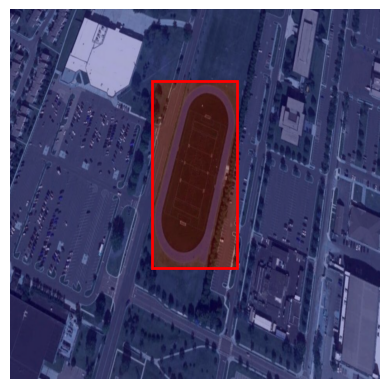

In [130]:
# Sélection de l'indice de l'image à visualiser
index = 0

# Récupération de l'image et des données associées à partir de l'ensemble de données personnalisé
img, data = datatrainmask[109]

# Conversion de l'image tensor en tableau numpy et permutation des dimensions pour l'affichage
img_np = img.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for display

# Récupération de l'identifiant de l'image à partir du DataFrame de l'ensemble de données personnalisé
image_id = datatrainmask.dflist[index]['imageid']

# Affichage de l'image avec ses boîtes englobantes et masques associés
plt.imshow(img_np)
plt.axis('off')

# Tracé des masques et des boîtes englobantes
for i, box in enumerate(data['boxes']):
    # Récupération des coordonnées de la boîte englobante
    x1, y1, x2, y2 = box.numpy()

    # Tracé de la boîte englobante
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # Récupération et affichage du masque
    mask = data['masks'][i].numpy().astype(np.float32)
    plt.imshow(mask, alpha=0.35, cmap='jet', interpolation='none')

# Affichage de l'image avec les boîtes englobantes et masques
plt.show()


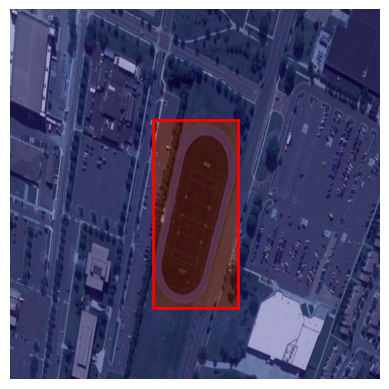

In [135]:
# Sélection de l'indice de l'image à visualiser
index = 109

# Récupération de l'image et des données associées à partir de l'ensemble de données personnalisé
img, data = datatrainmask[109]

# Conversion de l'image tensor en tableau numpy et permutation des dimensions pour l'affichage
img_np = img.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for display

# Récupération de l'identifiant de l'image à partir du DataFrame de l'ensemble de données personnalisé
image_id = datatrainmask.dflist[index]['imageid']

# Affichage de l'image avec ses boîtes englobantes et masques associés
plt.imshow(img_np)
plt.axis('off')

# Tracé des masques et des boîtes englobantes
for i, box in enumerate(data['boxes']):
    # Récupération des coordonnées de la boîte englobante
    x1, y1, x2, y2 = box.numpy()

    # Tracé de la boîte englobante
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # Récupération et affichage du masque
    mask = data['masks'][i].numpy().astype(np.float32)
    plt.imshow(mask, alpha=0.35, cmap='jet', interpolation='none')

# Affichage de l'image avec les boîtes englobantes et masques
plt.show()


## Vizualizing boundary boxes and the mask of the stadium (Normal and flipped One)

In [31]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import time


# Modelisation

In [161]:
def get_model(num_classes):
    """
    Renvoie un modèle Mask R-CNN pré-entraîné personnalisé pour un problème spécifique.

    Args:
        num_classes (int): Nombre de classes d'objets dans le problème spécifique.

    Returns:
        torchvision.models.detection.mask_rcnn.MaskRCNN: Modèle Mask R-CNN personnalisé.

    """
    # Chargement du modèle pré-entraîné sur le jeu de données COCO
    # Load the pretrained ResNet-50 backbone (weights imagenet)
    resnet = torchvision.models.resnet50(pretrained=True)

    # Create an instance of the Mask R-CNN model with the pretrained backbone
    model = maskrcnn_resnet50_fpn(pretrained=False)
    model.backbone.body.load_state_dict(resnet.state_dict(), strict=False)

    # Personnalisation de la couche de prédiction des boîtes englobantes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

    # Personnalisation de la couche de prédiction des masques
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [162]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
learning_rate = 0.001
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.005)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [132]:
!nvidia-smi

Thu May  9 17:06:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              32W /  70W |  14813MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   3.534. Mask-only loss:   0.656
    [Batch  10 /  51] Batch train loss:   2.672. Mask-only loss:   0.435
    [Batch  15 /  51] Batch train loss:   1.759. Mask-only loss:   0.700
    [Batch  20 /  51] Batch train loss:   1.404. Mask-only loss:   0.483
    [Batch  25 /  51] Batch train loss:   1.258. Mask-only loss:   0.416
    [Batch  30 /  51] Batch train loss:   1.345. Mask-only loss:   0.481
    [Batch  35 /  51] Batch train loss:   1.281. Mask-only loss:   0.397
    [Batch  40 /  51] Batch train loss:   1.138. Mask-only loss:   0.436
    [Batch  45 /  51] Batch train loss:   1.019. Mask-only loss:   0.383
    [Batch  50 /  51] Batch train loss:   1.024. Mask-only loss:   0.373
    [Batch  51 /  51] Batch train loss:   1.287. Mask-only loss:   0.493
[Epoch  1 /  8] Train mask-only loss:   0.523
[Epoch  1 /  8] Train loss:   1.799. [126 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   1.020. Mask-only 

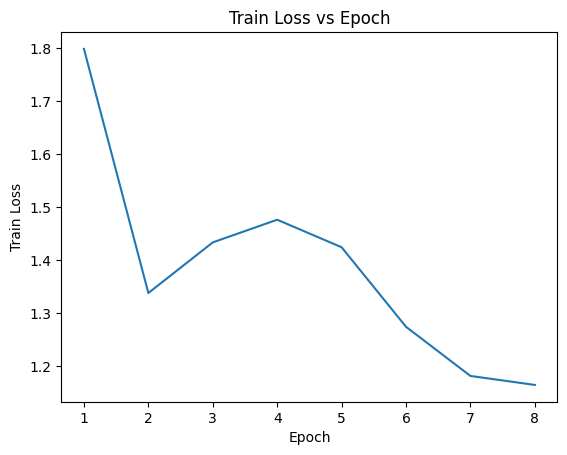

In [164]:

num_classes = 11  # Exemple avec 11 classes (arrière-plan + objets)

# Obtention du modèle
modelsgd = get_model(num_classes)
modelsgd.to(DEVICE)
modelsgd.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
params = [p for p in modelsgd.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]


# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modelsgd(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modelsgd.state_dict(), f"pytorch_model-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()


In [136]:
print("test")

test


Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   1.468. Mask-only loss:   0.706
    [Batch  10 /  51] Batch train loss:   1.184. Mask-only loss:   0.500
    [Batch  15 /  51] Batch train loss:   1.368. Mask-only loss:   0.265
    [Batch  20 /  51] Batch train loss:   0.986. Mask-only loss:   0.374
    [Batch  25 /  51] Batch train loss:   0.983. Mask-only loss:   0.329
    [Batch  30 /  51] Batch train loss:   1.436. Mask-only loss:   0.351
    [Batch  35 /  51] Batch train loss:   0.886. Mask-only loss:   0.314
    [Batch  40 /  51] Batch train loss:   1.189. Mask-only loss:   0.517
    [Batch  45 /  51] Batch train loss:   0.969. Mask-only loss:   0.421
    [Batch  50 /  51] Batch train loss:   1.141. Mask-only loss:   0.479
    [Batch  51 /  51] Batch train loss:   0.731. Mask-only loss:   0.356
[Epoch  1 /  8] Train mask-only loss:   0.548
[Epoch  1 /  8] Train loss:   1.439. [128 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   1.350. Mask-only 

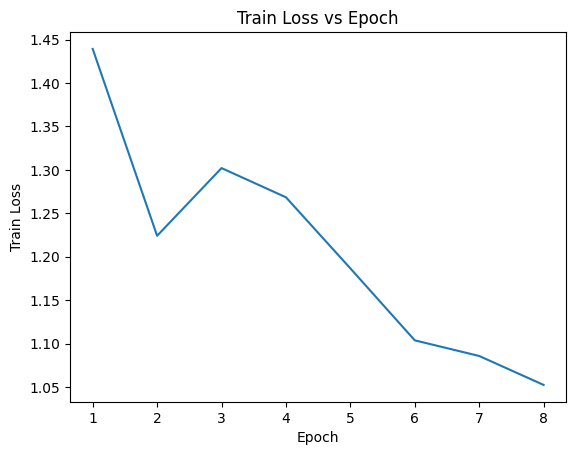

In [113]:

# Obtention du modèle
modeladam = get_model(num_classes)
modeladam.to(DEVICE)
modeladam.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
params = [p for p in modeladam.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]


# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modeladam(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modeladam.state_dict(), f"pytorch_model_adam-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()

Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   6.402. Mask-only loss:   4.143
    [Batch  10 /  51] Batch train loss:   2.065. Mask-only loss:   0.635
    [Batch  15 /  51] Batch train loss:   1.420. Mask-only loss:   0.460
    [Batch  20 /  51] Batch train loss:   1.213. Mask-only loss:   0.521
    [Batch  25 /  51] Batch train loss:   1.312. Mask-only loss:   0.547
    [Batch  30 /  51] Batch train loss:   1.457. Mask-only loss:   0.523
    [Batch  35 /  51] Batch train loss:   0.980. Mask-only loss:   0.506
    [Batch  40 /  51] Batch train loss:   1.697. Mask-only loss:   0.549
    [Batch  45 /  51] Batch train loss:   1.276. Mask-only loss:   0.426
    [Batch  50 /  51] Batch train loss:   1.279. Mask-only loss:   0.531
    [Batch  51 /  51] Batch train loss:   0.856. Mask-only loss:   0.412
[Epoch  1 /  8] Train mask-only loss:   0.892
[Epoch  1 /  8] Train loss:   2.029. [132 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   1.466. Mask-only 

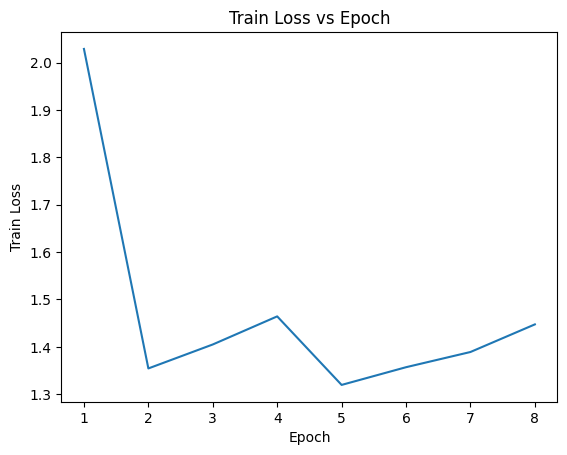

In [53]:
# Obtention du modèle
modelrms = get_model(num_classes)
modelrms.to(DEVICE)
modelrms.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
learning_rate=0.0001
params = [p for p in modelrms.parameters() if p.requires_grad]
optimizer = torch.optim.RMSprop(params, lr=learning_rate,alpha=0.9, weight_decay=0.005, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]


# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modelrms(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modelrms.state_dict(), f"pytorch_model_rms-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   2.781. Mask-only loss:   1.706
    [Batch  10 /  51] Batch train loss:   0.976. Mask-only loss:   0.418
    [Batch  15 /  51] Batch train loss:   4.201. Mask-only loss:   0.392
    [Batch  20 /  51] Batch train loss:   0.858. Mask-only loss:   0.130
    [Batch  25 /  51] Batch train loss:   0.931. Mask-only loss:   0.401
    [Batch  30 /  51] Batch train loss:   1.210. Mask-only loss:   0.376
    [Batch  35 /  51] Batch train loss:   1.079. Mask-only loss:   0.407
    [Batch  40 /  51] Batch train loss:   1.028. Mask-only loss:   0.425
    [Batch  45 /  51] Batch train loss:   1.066. Mask-only loss:   0.505
    [Batch  50 /  51] Batch train loss:   1.485. Mask-only loss:   0.659
    [Batch  51 /  51] Batch train loss:   0.850. Mask-only loss:   0.377
[Epoch  1 /  8] Train mask-only loss:   0.736
[Epoch  1 /  8] Train loss:   1.750. [122 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   1.534. Mask-only 

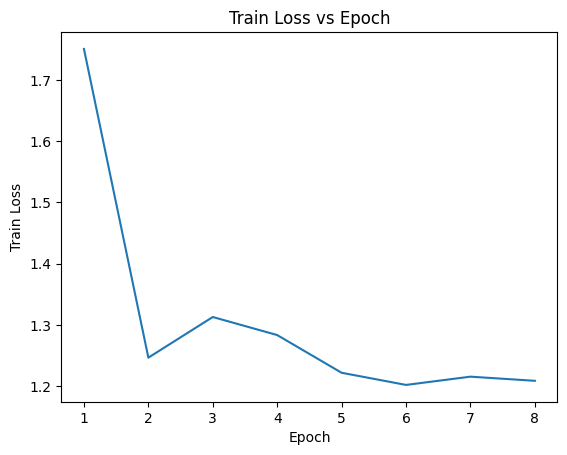

In [55]:
# Obtention du modèle
modeladamsgd = get_model(num_classes)
modeladamsgd.to(DEVICE)
modeladamsgd.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
learning_rate=0.001
paramsadam = [p for p in modeladamsgd.parameters() if p.requires_grad]
paramssgd = [p for p in modeladamsgd.parameters() if p.requires_grad]

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]

optimizer = torch.optim.Adam(paramsadam, lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    if epoch==5:
        optimizer = torch.optim.SGD(paramssgd, lr=0.001, momentum=0.9, weight_decay=0.005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modeladamsgd(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modeladamsgd.state_dict(), f"pytorch_model_adamsgd-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   3.526. Mask-only loss:   0.677
    [Batch  10 /  51] Batch train loss:   2.242. Mask-only loss:   0.429
    [Batch  15 /  51] Batch train loss:   1.697. Mask-only loss:   0.630
    [Batch  20 /  51] Batch train loss:   1.432. Mask-only loss:   0.502
    [Batch  25 /  51] Batch train loss:   1.223. Mask-only loss:   0.385
    [Batch  30 /  51] Batch train loss:   1.193. Mask-only loss:   0.437
    [Batch  35 /  51] Batch train loss:   1.426. Mask-only loss:   0.527
    [Batch  40 /  51] Batch train loss:   1.253. Mask-only loss:   0.523
    [Batch  45 /  51] Batch train loss:   0.976. Mask-only loss:   0.437
    [Batch  50 /  51] Batch train loss:   1.283. Mask-only loss:   0.463
    [Batch  51 /  51] Batch train loss:   1.336. Mask-only loss:   0.459
[Epoch  1 /  8] Train mask-only loss:   0.495
[Epoch  1 /  8] Train loss:   1.739. [126 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   1.269. Mask-only 

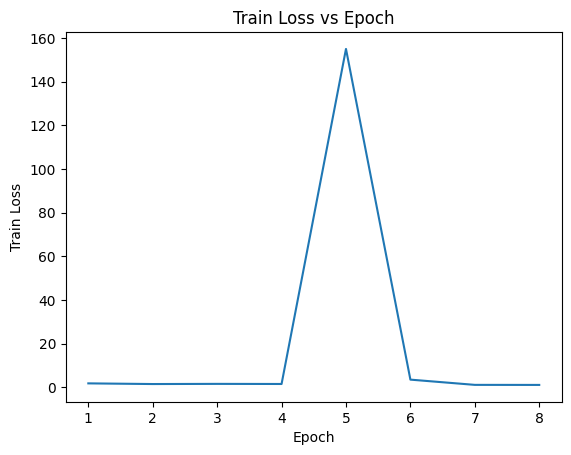

In [60]:
# Obtention du modèle
modelsgdadam = get_model(num_classes)
modelsgdadam.to(DEVICE)
modelsgdadam.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
learning_rate=0.001
paramsadam = [p for p in modelsgdadam.parameters() if p.requires_grad]
paramssgd = [p for p in modelsgdadam.parameters() if p.requires_grad]

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]


optimizer = torch.optim.SGD(paramssgd, lr=learning_rate,momentum=0.9 ,weight_decay=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    if epoch==5:
        optimizer = torch.optim.Adam(paramsadam, lr=0.001, weight_decay=0)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modelsgdadam(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modelsgdadam.state_dict(), f"pytorch_model_sgdadam-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()

Starting epoch 1 of 8
    [Batch   5 /  51] Batch train loss:   3.677. Mask-only loss:   0.556
    [Batch  10 /  51] Batch train loss:   3.654. Mask-only loss:   0.648
    [Batch  15 /  51] Batch train loss:   3.880. Mask-only loss:   0.997
    [Batch  20 /  51] Batch train loss:   3.439. Mask-only loss:   0.605
    [Batch  25 /  51] Batch train loss:   3.310. Mask-only loss:   0.741
    [Batch  30 /  51] Batch train loss:   3.290. Mask-only loss:   1.065
    [Batch  35 /  51] Batch train loss:   2.695. Mask-only loss:   0.757
    [Batch  40 /  51] Batch train loss:   2.551. Mask-only loss:   0.603
    [Batch  45 /  51] Batch train loss:   2.490. Mask-only loss:   1.104
    [Batch  50 /  51] Batch train loss:   2.298. Mask-only loss:   1.021
    [Batch  51 /  51] Batch train loss:   1.649. Mask-only loss:   0.457
[Epoch  1 /  8] Train mask-only loss:   0.855
[Epoch  1 /  8] Train loss:   3.221. [125 secs]
Starting epoch 2 of 8
    [Batch   5 /  51] Batch train loss:   2.062. Mask-only 

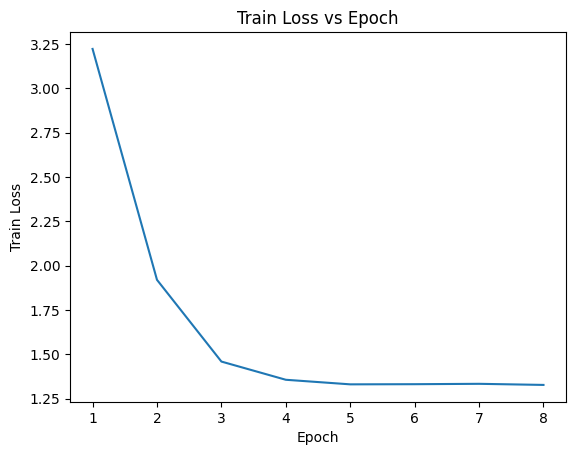

In [120]:
# Obtention du modèle
modeladelta = get_model(num_classes)
modeladelta.to(DEVICE)
modeladelta.train()  # Met le modèle en mode entraînement

# Paramètres d'optimisation
learning_rate=0.001
params = [p for p in modeladelta.parameters() if p.requires_grad]
optimizer = torch.optim.Adadelta(params, lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Nombre d'époques et de lots (batches)
num_epochs = 8
n_batches = len(train_loader)

train_losses = []
class_accuracies = [[] for _ in range(num_classes)]


# Boucle d'entraînement
for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch} of {num_epochs}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    # Itération sur les lots (batches)
    for batch_idx, (images, data) in enumerate(train_loader, 1):

        # Déballage des données en tenseurs séparés
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in data]

        # Passage avant (forward pass)
        loss_dict = modeladelta(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 5 == 0 or batch_idx == 51:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")

        # Enregistrement du modèle après chaque lot (batch)
        torch.save(modeladelta.state_dict(), f"pytorch_model_adelta-e{epoch}.bin")

    # Calcul des pertes d'entraînement
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_losses.append(train_loss)
    elapsed = time.time() - time_start

    # Affichage des pertes
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

#Plotting the Train Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.show()

## Evaluation

In [ ]:
def compute_overlap(boxes, query_boxes):
    """
    Args
        boxes:       (N, 4) ndarray of float
        query_boxes: (4)    ndarray of float
    Returns
        overlaps: (N) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    overlaps = np.zeros((N), dtype=np.float64)
    box_area = (
        (query_boxes[2] - query_boxes[0]) *
        (query_boxes[3] - query_boxes[1])
    )
    for n in range(N):
        iw = (
            min(boxes[n, 2], query_boxes[2]) -
            max(boxes[n, 0], query_boxes[0])
        )
        if iw > 0:
            ih = (
                min(boxes[n, 3], query_boxes[3]) -
                max(boxes[n, 1], query_boxes[1])
            )
            if ih > 0:
                ua = np.float64(
                    (boxes[n, 2] - boxes[n, 0]) *
                    (boxes[n, 3] - boxes[n, 1]) +
                    box_area - iw * ih
                )
                overlaps[n] = iw * ih / ua
    return overlaps


def cehck_if_true_or_false_positive(annotations, detections, iou_threshold):
    annotations = np.array(annotations, dtype=np.float64)
    scores = []
    false_positives = []
    true_positives = []
    detected_annotations = [] # a GT box should be mapped only one predicted box at most.
    for d in detections:
        scores.append(d[4])
        if len(annotations) == 0:
            false_positives.append(1)
            true_positives.append(0)
            continue
        overlaps = compute_overlap(annotations, d[:4])
        assigned_annotation = np.argmax(overlaps)
        max_overlap = overlaps[assigned_annotation]
        if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
            false_positives.append(0)
            true_positives.append(1)
            detected_annotations.append(assigned_annotation)
        else:
            false_positives.append(1)
            true_positives.append(0)
    return scores, false_positives, true_positives


def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def mean_average_precision_for_boxes(,iou_threshold=0.5):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
    preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))

    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(np.str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue
                
            num_annotations += len(annotations)
            
            scr, fp, tp = cehck_if_true_or_false_positive(annotations, detections, iou_threshold)
            scores += scr
            false_positives += fp
            true_positives += tp

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations, _, _) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision
    mean_ap = precision / present_classes
    if verbose:
        print('mAP: {:.6f}'.format(mean_ap))
    return mean_ap, average_precisions



In [174]:
torch.cuda.memory_summary(device=DEVICE, abbreviated=True)
torch.cuda.empty_cache()

In [84]:
def generate_output_dataframe(model, test_loader, dflist, DEVICE='cuda'):
    model.to(DEVICE)
    model.eval()
    output_list = []

    with torch.no_grad():
        for batch_idx, (images, target) in enumerate(test_loader):
            images = list(image.to(DEVICE) for image in images)
            outputs = model(images)

            # Iterate over outputs and corresponding image IDs in the batch
            for output, image_id in zip(outputs, dflist[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size]):
                # Extract bounding boxes and classes
                boxes = output['boxes'].tolist()
                classes = output['labels'].tolist()

                # Add image ID, boxes, and classes to the output list
                output_list.append({'imageid': image_id['imageid'], 'boxes': boxes, 'classes': classes})

    # Convert the output list to a pandas DataFrame
    df_outputs = pd.DataFrame(output_list)
    return df_outputs

In [138]:
sgd_preds = generate_output_dataframe(modelsgd, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [140]:
adam_preds = generate_output_dataframe(modeladam, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [142]:
rms_preds = generate_output_dataframe(modelrms, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [144]:
adelta_preds = generate_output_dataframe(modeladelta, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [146]:
adamsgdpreds = generate_output_dataframe(modeladamsgd, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [148]:
sgdadampreds = generate_output_dataframe(modelsgdadam, test_loader, test_loader.dataset.dflist, DEVICE='cuda')

In [150]:
sgd_preds

,imageid,boxes,classes
0,001,"[[570.7300415039062, 472.79754638671875, 632.1...","[1, 1, 1, 1, 7, 1, 2, 1, 1, 1, 7, 7, 1, 7, 7, ..."
1,002,"[[64.11534881591797, 306.2840881347656, 143.56...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, ..."
2,003,"[[767.499267578125, 363.99688720703125, 840.63...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, ..."
3,004,"[[454.1683349609375, 68.17291259765625, 508.06...","[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, ..."
4,005,"[[596.8611450195312, 141.86819458007812, 675.9...","[1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
244,642,"[[766.3388671875, 446.9626770019531, 794.75482...","[4, 7, 4, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, ..."
245,643,"[[369.3902282714844, 166.1839141845703, 422.29...","[5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 1, 5, 5, 5, ..."
246,644,"[[405.3917541503906, 193.96563720703125, 572.0...","[7, 4, 7, 7, 7, 7, 4, 7, 4, 7, 4, 1, 7, 7, 1, ..."
247,645,"[[663.9750366210938, 193.3266143798828, 727.17...","[4, 4, 4, 4, 7, 4, 4, 4, 4, 7, 7, 7, 4, 7, 7, ..."


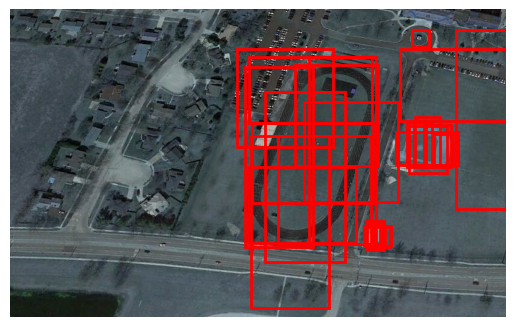

In [199]:
# Sélection de l'indice de l'image à visualiser
imageid = '645'

# Récupération de l'image et des données associées à partir de l'ensemble de données personnalisé
data = sgd_preds[sgd_preds['imageid']==imageid]

img, x = testtrainmask[247]

img_np = img.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for display

# Affichage de l'image avec ses boîtes englobantes et masques associés
plt.imshow(img_np)
plt.axis('off')


# Tracé des masques et des boîtes englobantes
for boxes in data['boxes']:
    for box in boxes:
        # Récupération des coordonnées de la boîte englobante
        x1, y1, x2, y2 = box[0],box[1],box[2],box[3]

        # Tracé de la boîte englobante
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)


# Affichage de l'image avec les boîtes englobantes et masques
plt.show()